# MLGeometry guide

This introduction demonstrates how to use MLGeometry to:
1. Generate a hypersurface.
2. Build a bihomogeneous neural network.
3. Use the model to compute numerical Calabi-Yau metrics with the embedding method.
4. Plot $\eta$ on a rational curve.

## Install the package (on Colab)

In [ ]:
!pip install MLGeometry-JAX

## Configure imports

In [1]:
import numpy as np
import sympy as sp
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
import pickle

import MLGeometry as mlg
from MLGeometry import bihomoNN as bnn
from typing import Sequence, Any, List, Callable

Import the libraries to plot the $\eta$ on the rational curve (see the last section):

In [2]:
import os
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
mlg.set_precision(64)

MLGeometry: Precision set to FP64 (x64 enabled).


## Set a random seed (optional)
Some random seed might be bad for numerical calulations. If there are any errors during the training, you may want to try a different seed.

In [4]:
np.random.seed(7)
rng = jax.random.PRNGKey(7)

## Define a hypersurface
First define a set of coordinates and a function as sympy symbols:

In [5]:
z0, z1, z2, z3, z4 = sp.symbols('z0, z1, z2, z3, z4')
Z = [z0,z1,z2,z3,z4]
f = z0**5 + z1**5 + z2**5 + z3**5 + z4**5 + 0.0*z0*z1*z2*z3*z4

Then define a hypersurface as a collection of points which solve the equation f = 0, using the `Hypersurface` class in the `mlg.hypersurface` module. The parameter n_pairs is the number of random pairs of points used to form the random lines in $\mathbf{CP}^{N+1}$. Then we take the intersections of those random lines and the hypersurface. By Bezout's theorem, each line intersects the hypersurface in precisely d points where d is the number of homogeneous coordinates. So the total number of points is d * n_pairs.

In [6]:
n_pairs = 10000
HS_train = mlg.hypersurface.Hypersurface(Z, f, n_pairs)
HS_test = mlg.hypersurface.Hypersurface(Z, f, n_pairs)

The Hypersurface class will take care of the patchwork automatically. Let's use the `list_patches` function to check the number of points on each patch:

In [7]:
HS_train.list_patches()

Number of Patches: 5
Points on patch 1 : 10171
Points on patch 2 : 10038
Points on patch 3 : 9783
Points on patch 4 : 10047
Points on patch 5 : 9961


You can also invoke this method on one of the patches to check the distribution on the subpatches:

In [8]:
HS_train.patches[0].list_patches()

Number of Patches: 4
Points on patch 1 : 2588
Points on patch 2 : 2530
Points on patch 3 : 2512
Points on patch 4 : 2541


The Hypersurface class contains some symbolic and numerical methods as well, which will be introduced elsewhere.

## Training with JAX

### Generate datasets
The `mlg.dataset.generate_dataset` function converts a hypersurface to a dataset dictionary, which has four componets: the points on the hypersurface, the volume form $\small \Omega \wedge \bar\Omega$, the mass reweighting the points distribution and the restriction which restricts the Kähler metric to a subpatch. The restriction contains an extra linear transformation so that points on different affine patches can all be processed in one call. It is also possible to generate a dataset only on one affine patch.

In [7]:
train_set = mlg.dataset.generate_dataset(HS_train)
test_set = mlg.dataset.generate_dataset(HS_test)

Shuffle and batch the datasets:

Let's look at what is inside a dataset:

In [8]:
for key, val in train_set.items():
    print(f"  {key}: shape {val.shape}, dtype {val.dtype}")

  points: shape (50000, 5), dtype complex64
  Omega_Omegabar: shape (50000,), dtype float32
  mass: shape (50000,), dtype float32
  restriction: shape (50000, 3, 5), dtype complex64


### Build a bihomogeneous neural network

The `mlg.bihomoNN` module provides the necessary layers (e.g. `Bihomogeneous` and `SquareDense` ) to construct the Kähler potential with a bihomogeneous neural network. Here is an example of a two-hidden-layer network (k = 4) with 70 and 100 hidden units:

In [9]:
class BihomogeneousNetwork(nn.Module):
    layers: List[int]
    amp: Any = 1.0
    d: int = 5

    @nn.compact
    def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
        x = bnn.Bihomogeneous(d=self.d)(inputs)
        for feat in self.layers:
            x = bnn.SquareDense(features=feat)(x)
        x = bnn.SquareDense(features=1, activation=None)(x)

        return self.amp * jnp.log(x)

In [67]:
class SpectralNetwork(nn.Module):
    layers: List[int]
    amp: Any = 1.0
    activation: Callable = jnp.tanh
    d: int = 5

    @nn.compact
    def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
        x = inputs
        x = bnn.Spectral(d=self.d)(inputs)
        for feat in self.layers:
            x = bnn.Dense(features=feat, activation=self.activation)(x)
        x = bnn.Dense(features=1)(x)

        #return jnp.sinh(x)
        return self.amp * jnp.sinh(x)
        #return self.amp * jnp.sign(x) * (jnp.exp(jnp.abs(x)) - 1.0)

In [10]:
K0 = BihomogeneousNetwork(layers=[64, 256, 512])

In [11]:
BATCH_SIZE = 1000

In [12]:
output_dir = 'trained_models'
os.makedirs(output_dir, exist_ok=True)
model_path = os.path.join(output_dir, '64_256_512_1_lbfgs.pkl')
    
with open(model_path, 'rb') as f_pkl:
    params0 = pickle.load(f_pkl)

Loop over the batches and train the network:

In [14]:
sigma_test = mlg.loss.evaluate_dataset(K0, params0, test_set, mlg.loss.weighted_MAPE, BATCH_SIZE*10)
E_test = mlg.loss.evaluate_dataset(K0, params0, test_set, mlg.loss.weighted_MSPE, BATCH_SIZE*10)
print("sigma_test = %.5e" % sigma_test)
print("E_test = %.5e" % E_test)

sigma_test = 7.39692e-04
E_test = 1.04536e-06


#### Print out the metrics
One can check the explicit form of the trained metrics by:

In [15]:
train_set['cymetric'] = mlg.loss.compute_cy_metric(K0, params0, train_set)
test_set['cymetric'] = mlg.loss.compute_cy_metric(K0, params0, test_set)

In [33]:
amp1 = mlg.loss.evaluate_dataset(K0, params0, test_set, mlg.loss.max_abs_error, BATCH_SIZE*10)
print(amp1)
#amp1 = 0.01

0.0017554967871387522


In [28]:
K1 = BihomogeneousNetwork(layers=[64, 64])

In [30]:
K1 = SpectralNetwork()

In [68]:
K1 = SpectralNetwork(layers=[64, 64, 64], amp = amp1, activation = jnp.tanh)

In [62]:
BATCH_SIZE = 1000
optimizer = optax.adam(learning_rate=0.001)

params1, final_loss1 = mlg.trainer.train_optax(
    model=K1,
    params=None, 
    dataset=train_set,
    epochs=100,
    optimizer=optimizer,
    batch_size=BATCH_SIZE,
    loss_metric=mlg.loss.weighted_MAPE_amp_scaled,
    residue_amp=1.0,
    seed=42,
    verbose=True
)

Initializing parameters for input dimension 5...
Starting training with 100 epochs, 50 batches/epoch...
Epoch 1: Avg Loss = 7.40755e-04
Epoch 10: Avg Loss = 7.38126e-04
Epoch 20: Avg Loss = 7.37155e-04
Epoch 30: Avg Loss = 7.35647e-04
Epoch 40: Avg Loss = 7.34971e-04
Epoch 50: Avg Loss = 7.32784e-04
Epoch 60: Avg Loss = 7.31083e-04
Epoch 70: Avg Loss = 7.29208e-04
Epoch 80: Avg Loss = 7.26923e-04
Epoch 90: Avg Loss = 7.24289e-04
Epoch 100: Avg Loss = 7.21625e-04
Training finished in 504.03s. Final Loss: 7.21625e-04


In [69]:
BATCH_SIZE = 1000
optimizer = optax.adam(learning_rate=0.001)

params1, final_loss1 = mlg.trainer.train_optax(
    model=K1,
    params=None, 
    dataset=train_set,
    epochs=100,
    optimizer=optimizer,
    batch_size=BATCH_SIZE,
    loss_metric=mlg.loss.weighted_MAPE_amp_scaled,
    residue_amp=amp1,
    seed=42,
    verbose=True
)

Initializing parameters for input dimension 5...
Starting training with 100 epochs, 50 batches/epoch...
Epoch 1: Avg Loss = 5.05818e+00
Epoch 10: Avg Loss = 5.11661e-01
Epoch 20: Avg Loss = 4.69193e-01
Epoch 30: Avg Loss = 4.66637e-01
Epoch 40: Avg Loss = 4.47121e-01
Epoch 50: Avg Loss = 4.43519e-01
Epoch 60: Avg Loss = 4.41885e-01
Epoch 70: Avg Loss = 4.33500e-01
Epoch 80: Avg Loss = 4.33204e-01
Epoch 90: Avg Loss = 4.30123e-01
Epoch 100: Avg Loss = 4.28081e-01
Training finished in 554.68s. Final Loss: 4.28081e-01


In [32]:
K1.apply(params1, train_set['points'][10])

Array([0.00021974], dtype=float64)

In [70]:
sigma_test = mlg.loss.evaluate_dataset(K1, params1, test_set, mlg.loss.weighted_MAPE, BATCH_SIZE*10, residue_amp=amp1)
E_test = mlg.loss.evaluate_dataset(K1, params1, test_set, mlg.loss.weighted_MSPE, BATCH_SIZE*10, residue_amp=amp1)
print("sigma_test = %.5e" % sigma_test)
print("E_test = %.5e" % E_test)

sigma_test = 7.54894e-04
E_test = 1.07704e-06


In [34]:
params2, final_loss_lbfgs = mlg.trainer.train_lbfgs(
    model=model1,
    params=params1, 
    dataset=train_set,
    max_iter=20,
    loss_metric=loss_metric,
    batch_size=1000, # Enable gradient accumulation
    verbose=True,
    residue_amp=amp
)

Starting L-BFGS training (Accumulated Gradients)...
Initial Loss: 0.02977
Iteration 1: Loss = 0.02892
Iteration 2: Loss = 0.02870
Iteration 3: Loss = 0.02791
Iteration 4: Loss = 0.02780
Iteration 5: Loss = 0.02775
Iteration 6: Loss = 0.02756
Iteration 7: Loss = 0.02753
Iteration 8: Loss = 0.02752
Iteration 9: Loss = 0.02750
Iteration 10: Loss = 0.02749
Iteration 11: Loss = 0.02746
Iteration 12: Loss = 0.02744
Iteration 13: Loss = 0.02740
Iteration 14: Loss = 0.02737
Iteration 15: Loss = 0.02732
Iteration 16: Loss = 0.02728
Iteration 17: Loss = 0.02721
Iteration 18: Loss = 0.02718
Iteration 19: Loss = 0.02709
Iteration 20: Loss = 0.02707
L-BFGS finished in 295.03s. Final Loss: 0.02707


In [51]:
cymetric_delta = mlg.loss.compute_cy_metric(model1, params2, train_set)
metric_total = train_set['cymetric'] + cymetric_delta

det_vol = jnp.real(jax.vmap(jnp.linalg.det)(metric_total))

omega_omegabar = train_set['Omega_Omegabar']
mass = train_set['mass']
weights = mass / jnp.sum(mass)
factor = jnp.sum(weights*det_vol/omega_omegabar)
det_omega = det_vol / factor

loss = mlg.loss.weighted_MAPE(omega_omegabar, det_omega, mass)

In [52]:
loss

Array(0.00630686, dtype=float32)

In [54]:
train_set['cymetric'] = train_set['cymetric'] + cymetric_delta

In [37]:
mlg.loss.max_error(omega_omegabar, det_omega, mass)

Array(0.05189428, dtype=float32)

In [55]:
cymetric_delta = mlg.loss.compute_cy_metric(model1, params2, test_set)
metric_total = test_set['cymetric'] + cymetric_delta

det_vol = jnp.real(jax.vmap(jnp.linalg.det)(metric_total))

omega_omegabar = test_set['Omega_Omegabar']
mass = test_set['mass']
weights = mass / jnp.sum(mass)
factor = jnp.sum(weights*det_vol/omega_omegabar)
det_omega = det_vol / factor

loss = mlg.loss.weighted_MAPE(omega_omegabar, det_omega, mass)

In [56]:
loss

Array(0.00715103, dtype=float32)

In [57]:
test_set['cymetric'] = test_set['cymetric'] + cymetric_delta

In [72]:
amp2 = mlg.loss.max_abs_error(omega_omegabar, det_omega, mass)

In [74]:
mlg.loss.weighted_RMSE(omega_omegabar/amp, det_omega/amp, mass)

Array(0.08712792, dtype=float32)

In [73]:
amp2

Array(0.01521459, dtype=float32)

In [99]:
class phi2(nn.Module):
    @nn.compact
    def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
        x = bnn.Bihomogeneous(d=len(Z))(inputs)
        x = bnn.SquareDense(features=64)(x)
        x = bnn.SquareDense(features=128)(x)
        x = bnn.SquareDense(features=256)(x)
        x = bnn.SquareDense(features=1, activation=None)(x)
        return amp2 * jnp.log(x)

In [100]:
model2 = phi2()

In [101]:
def weighted_MAPE_scaled2(y_true: jnp.ndarray, y_pred: jnp.ndarray, mass: jnp.ndarray) -> jnp.ndarray:
    """Weighted Mean Absolute Percentage Error."""
    weights = mass / jnp.sum(mass)
    return jnp.sum(jnp.abs(y_true - y_pred) / y_true * weights) / amp2

In [102]:
loss_metric = weighted_MAPE_scaled2
BATCH_SIZE = 1000
optimizer = optax.adam(learning_rate=0.001)

In [103]:
params3, final_loss3 = mlg.trainer.train_optax(
    model=model2,
    params=None, 
    dataset=train_set,
    optimizer=optimizer,
    epochs=300,
    batch_size=BATCH_SIZE,
    loss_metric=loss_metric,
    seed=10, 
    verbose=True,
    residue_amp=amp2,
)

Initializing parameters for input dimension 5...
Starting training with 300 epochs, 50 batches/epoch...
Epoch 1: Avg Loss = 0.98891
Epoch 10: Avg Loss = 0.42835
Epoch 20: Avg Loss = 0.42454
Epoch 30: Avg Loss = 0.42385
Epoch 40: Avg Loss = 0.42337
Epoch 50: Avg Loss = 0.42233
Epoch 60: Avg Loss = 0.42152
Epoch 70: Avg Loss = 0.42043
Epoch 80: Avg Loss = 0.41826
Epoch 90: Avg Loss = 0.41692
Epoch 100: Avg Loss = 0.41619
Epoch 110: Avg Loss = 0.41497
Epoch 120: Avg Loss = 0.41476
Epoch 130: Avg Loss = 0.41406
Epoch 140: Avg Loss = 0.41353
Epoch 150: Avg Loss = 0.41303
Epoch 160: Avg Loss = 0.41316
Epoch 170: Avg Loss = 0.41264
Epoch 180: Avg Loss = 0.41185
Epoch 190: Avg Loss = 0.41051
Epoch 200: Avg Loss = 0.40874
Epoch 210: Avg Loss = 0.40363
Epoch 220: Avg Loss = 0.39768
Epoch 230: Avg Loss = 0.39285
Epoch 240: Avg Loss = 0.38566
Epoch 250: Avg Loss = 0.37519
Epoch 260: Avg Loss = 0.35918
Epoch 270: Avg Loss = 0.34083
Epoch 280: Avg Loss = 0.31817
Epoch 290: Avg Loss = 0.29687
Epoch 3

In [104]:
cymetric_delta = mlg.loss.compute_cy_metric(model2, params3, train_set)
metric_total = train_set['cymetric'] + cymetric_delta

det_vol = jnp.real(jax.vmap(jnp.linalg.det)(metric_total))

omega_omegabar = train_set['Omega_Omegabar']
mass = train_set['mass']
weights = mass / jnp.sum(mass)
factor = jnp.sum(weights*det_vol/omega_omegabar)
det_omega = det_vol / factor

loss = mlg.loss.weighted_MAPE(omega_omegabar, det_omega, mass)

In [105]:
loss

Array(0.00408141, dtype=float32)

In [106]:
mlg.loss.max_abs_error(omega_omegabar, det_omega, mass)

Array(0.00672522, dtype=float32)

In [107]:
params4, final_loss_lbfgs = mlg.trainer.train_lbfgs(
    model=model2,
    params=params3, 
    dataset=train_set,
    max_iter=50,
    loss_metric=loss_metric,
    batch_size=1000, # Enable gradient accumulation
    verbose=True,
    residue_amp=amp
)

Starting L-BFGS training (Accumulated Gradients)...
Initial Loss: 0.26826
Iteration 1: Loss = 0.26578
Iteration 2: Loss = 0.26464
Iteration 3: Loss = 0.26222
Iteration 4: Loss = 0.26063
Iteration 5: Loss = 0.25986
Iteration 6: Loss = 0.25916
Iteration 7: Loss = 0.25834
Iteration 8: Loss = 0.25752
Iteration 9: Loss = 0.25707
Iteration 10: Loss = 0.25665
Iteration 11: Loss = 0.25627
Iteration 12: Loss = 0.25595
Iteration 13: Loss = 0.25566
Iteration 14: Loss = 0.25539
Iteration 15: Loss = 0.25512
Iteration 16: Loss = 0.25487


KeyboardInterrupt: 

In [89]:
cymetric_delta = mlg.loss.compute_cy_metric(model2, params4, train_set)
metric_total = train_set['cymetric'] + cymetric_delta

det_vol = jnp.real(jax.vmap(jnp.linalg.det)(metric_total))

omega_omegabar = train_set['Omega_Omegabar']
mass = train_set['mass']
weights = mass / jnp.sum(mass)
factor = jnp.sum(weights*det_vol/omega_omegabar)
det_omega = det_vol / factor

loss = mlg.loss.weighted_MAPE(omega_omegabar, det_omega, mass)
print(loss)

0.006591698


In [90]:
cymetric_delta = mlg.loss.compute_cy_metric(model2, params4, test_set)
metric_total = test_set['cymetric'] + cymetric_delta

det_vol = jnp.real(jax.vmap(jnp.linalg.det)(metric_total))

omega_omegabar = test_set['Omega_Omegabar']
mass = test_set['mass']
weights = mass / jnp.sum(mass)
factor = jnp.sum(weights*det_vol/omega_omegabar)
det_omega = det_vol / factor

loss = mlg.loss.weighted_MAPE(omega_omegabar, det_omega, mass)
print(loss)

0.007356135


In [91]:
cymetric_delta

Array([[[ 7.71893933e-02+3.09664756e-08j,
         -1.67471971e-02+1.11519266e-03j,
          2.66354643e-02+2.42956840e-02j],
        [-1.67471562e-02-1.11527834e-03j,
          1.16057068e-01+2.23517418e-08j,
         -4.92643341e-02-2.43993532e-02j],
        [ 2.66354252e-02-2.42956933e-02j,
         -4.92642149e-02+2.43993215e-02j,
          1.20653756e-01-9.31322575e-10j]],

       [[ 6.90417737e-02+1.36205927e-08j,
         -2.01967341e-04-2.64164968e-03j,
         -1.89560244e-03-2.37878179e-03j],
        [-2.01980030e-04+2.64163921e-03j,
          7.17412829e-02-1.46683306e-08j,
         -2.76465784e-03+3.07646522e-04j],
        [-1.89556764e-03+2.37877155e-03j,
         -2.76464853e-03-3.07646202e-04j,
          6.90521747e-02+1.29221007e-08j]],

       [[ 7.60340840e-02+8.73114914e-09j,
         -5.37282787e-04-2.57899892e-03j,
          3.47939064e-03-7.22916157e-04j],
        [-5.37266489e-04+2.57903244e-03j,
          9.20413807e-02+2.20024958e-08j,
          3.23314033e-0

In [98]:
model2.apply(params4, test_set['points']) / amp2

Array([[-1.8288648],
       [-5.2468724],
       [-4.2695985],
       ...,
       [-2.7088165],
       [-2.788074 ],
       [-4.42008  ]], dtype=float32)

In [96]:
amp2

Array(0.01521459, dtype=float32)

In [50]:


theta, phi = np.linspace(0.001,np.pi+0.001, 400), np.linspace(0.001, 2*np.pi+0.001, 400)

points_list = []
for j in phi:
    for i in theta:
        t = complex(math.sin(i)*math.sin(j), math.cos(i)) / (math.sin(i)*math.cos(j))
        if np.absolute(t) <= 1:
            points_list.append([1, -1, t, 0, -t])
        else:
            # Use symmetry:
            points_list.append([1, -1, 1/t, 0, -1/t])



In [51]:
rc = mlg.hypersurface.Hypersurface(Z, f, points=points_list, norm_coordinate=0, max_grad_coordinate=0)
rc_dataset = mlg.dataset.generate_dataset(rc)

In [53]:
eta = mlg.loss.evaluate_dataset(K0, params0, rc_dataset, mlg.loss.eta_array, batch_size=1000)

In [54]:
R = np.abs(eta-1).reshape(400, 400)
THETA, PHI = np.meshgrid(theta, phi)
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
ZZ = R * np.cos(THETA)


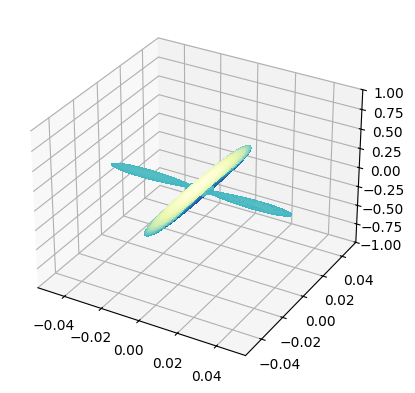

In [55]:


fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_zlim3d(-1.0, 1.0)
plot = ax.plot_surface(
    X, Y, ZZ, rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r,
    linewidth=0, antialiased=False)



In [60]:
R

array([[0.04771607, 0.04760427, 0.0473353 , ..., 0.0474662 , 0.04766993,
        0.04771607],
       [0.04771607, 0.0476043 , 0.04733541, ..., 0.04746628, 0.04766995,
        0.04771607],
       [0.04771607, 0.04760438, 0.04733569, ..., 0.04746648, 0.04766999,
        0.04771607],
       ...,
       [0.04771607, 0.04760437, 0.04733565, ..., 0.04746645, 0.04766998,
        0.04771607],
       [0.04771607, 0.04760429, 0.04733538, ..., 0.04746626, 0.04766995,
        0.04771607],
       [0.04771607, 0.04760427, 0.0473353 , ..., 0.0474662 , 0.04766993,
        0.04771607]], shape=(400, 400))